# ReadMe



In [1]:
import numba, time, pickle, random, copy
import numpy as np
from numba import njit 
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import brentq, fsolve , minimize, minimize_scalar
from scipy.io import savemat
import seaborn as sns; sns.set_theme()
from matplotlib.patches import Ellipse
from mpl_toolkits import mplot3d
from matplotlib import cm
from scipy.stats import norm
import scipy.stats

pd.set_option('display.max_columns', None)
from IPython.display import Image, IFrame
from pdf2image import convert_from_path
from IPython.display import Image
from io import BytesIO

 

In [2]:
pip install sequence_jacobian

Note: you may need to restart the kernel to use updated packages.


In [3]:
# SSJ imports
from sequence_jacobian import simple, create_model
import graphviz
from sequence_jacobian import drawdag
from sequence_jacobian.classes import JacobianDict, SteadyStateDict


In [4]:
# Firm problem blocks in file called "blocks_firm.py"

from blocks_firms import (firm_make_grid, firm_init, firm_operation, 
                          firm_exit, firm_continue, firm_incumbent_capital, firm_entrant_capital,
                          upperenv, upperenv_vec, logit_choice, 
                          batch_multiply_ith_dimension, get_lottery, forward_policy )



In [5]:
# Print functions
def print_ss(d):
    return pd.DataFrame(d.items()).set_index(0).rename(columns={1:'value'}).T

def print_aggregates(d, extra_vars = [], extra_only = 0):
    aggregate_vars = ['r', 'M','w', 'Z', 'Y', 'N', 'K', 'K_E', 'K_I', 
                      'total_mass', 'entrant_mass', 'EXIT_RATE', 'ENTRY_RATE', 'labor_mkt', 
                     'entrants_relative_size_incumbent', 'exiters_relative_size','mean_inv_rate','sd_inv_rate','inaction_rate']
    if extra_only == 0:
        aggregate_vars = sorted(list(set(aggregate_vars) | set(extra_vars)))
    else:
        aggregate_vars = extra_vars
    dict_you_want={}
    for key in aggregate_vars:
        if key in d:
            dict_you_want[key] = d[key]
    return pd.DataFrame(dict_you_want.items()).set_index(0).rename(columns={1:'value'}).T


 

In [6]:
print("test")

test


In [7]:
# Variable names
var_names = {'r':['Real Interest Rate', '$r$'], 
            'w':['Real Wage Rate', '$w$'],
            'X':['Aggregate TFP', '$X'],
            'N':['Employment', '$N$'], 
            'Y':['Output', '$Y$'],
            'K':['Capital', '$K$'],
            'I':['Investment', '$I$'], 
            'ENTRY_RATE':['Entry Rate', 'Entry Rate'],
            'EXIT_RATE':['Exit Rate', 'Exit Rate'],
            'total_mass':['Number of firms', 'Exit Rate'],
             'avg_entrants_prod':['Entrants avg. productivity', 'Exit Rate'],
             'avg_exiters_prod':['Exiters avg. productivity', 'Exit Rate'],
             'avg_prod':['Avg. Productivity', 'Exit Rate'],
            'entrants_relative_size_incumbent':['Entrant Relative Size', 'Exit Rate'],
             'exiters_relative_size':['Exiters Relative Size', 'Exit Rate'], 
            }


# Parameter Dict

In [8]:
# This initializes a dictionary with parameters and (r,nfa,B,G,Transfer) etc
def init_calibration():
    
    cali = {'alpha_k' : 0.3, 'alpha_l' : 0.7, 'theta' : 0.8,                          # production
                        'delta' : 0.1,                                                # depreciation
                        'c_0': 0, 'c_1': 0.03141,                                     # adjustment costs
                        'c_f': 0.00517026414467678,                                   # fixed operating costs
                        'c_e': 0.00517026414467678,                                   # fixed entry costs
                        'M'  : 131.00319187680464,                                    # mass of potential entrants
                        'taste_shock': 1e-03, 'taste_shock_e': 1e-03,                 # discrete-choice
                       }
    
    # grids
    cali.update({'rho_s': 0.55, 'sigma_s_unscaled' : 0.22, 'ns': 30,                  # productivity
                             'ns_e': 100, 'pareto': 2.69,                             # entrant signal
                             'kmin': 0.0001, 'kmax': 1.7, 'nk': 500,                  # capital
                            })
    sigma_s = cali['sigma_s_unscaled']/np.sqrt(1-cali['rho_s']**2)
    cali.update({'sigma_s': sigma_s})
    
    #################### others ####################
    
    # parameters
    cali.update({'gamma': 2,              # frisch  
                           })
    
    # variables
    cali.update({'r': 0.04, 'w': 3, 'X': 1 })     # X is the TFP 

    return cali 



# Firm Problem

## Policy and Value functions

Single backward iteration:
- Input: $V^{(2)}_{t+1}, \partial V^{(2)}_{t+1} \big/ \partial  k $
- Outputs: 
    - $V^{(2)}_{t}, \partial V^{(2)}_{t} \big/ \partial  k $
    - $k_{t}, l_{t}, y_{t}$ : period $t$ policies
    - $P_t$ : period $t$ exit probabilities
    - $P^e_t$ : period $t$ entry probabilities

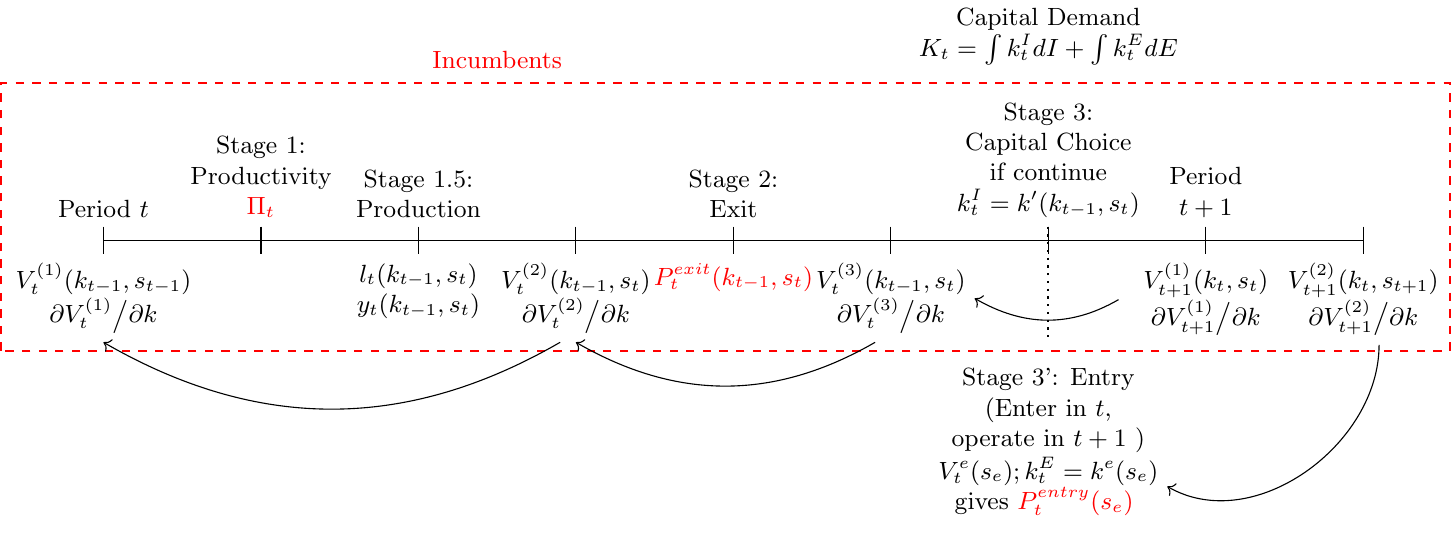

In [9]:
pages = convert_from_path("transition_figs-figure0.pdf", dpi=200)
buffer = BytesIO()
pages[0].save(buffer, format='PNG')
buffer.seek(0)
display(Image(data=buffer.getvalue()))

In [10]:
# single backward iteration starting from V^(2) and Va^(2)
# THESE STAGES ARE COMBINED BY THE STAGE BLOCKS IN SSJ
def firm_backward_iteration(V, Va, w, r, X, Pi_s, Pi_s_e_s, s_grid, k_grid, alpha_k, alpha_l, theta, delta, c_1, c_f, taste_shock, c_e, taste_shock_e):

    # compute profits for incumbent firms - period 't'
    profit, profit_k, l, y = firm_operation(w, X, s_grid, k_grid, alpha_k, alpha_l, theta)
    
    ############## Entrants ############## 
    
    # V is V^2_{t+1}(k_t,s_{t+1}). Note that s_{t+1} is what entrants will use for production
    V_e2, k_e, div_e  = firm_entrant_capital(Pi_s_e_s @ V, r, k_grid, c_e)  # values of entering and staying-out
    V_e1, Va_e, P_e = logit_choice(V_e2, Va, taste_shock_e, dV=0)                    # Here, Va as input and Va_e are redundant 
    
    ############## Incumbents ############## 
    
    # stage 1 of period (t+1) (productivity draw)
    V1 = Pi_s @ V 
    Va1 = Pi_s @ Va  
    
    # stage 3 of period (t) (capital policy)
    V3, Va3, k, div = firm_incumbent_capital(V1, Va1, w, r, X, profit, profit_k, k_grid, s_grid, alpha_k, alpha_l, theta, delta, c_1, c_f)

    # stage 2 of period (t) (exit choice)
    V2, Va2, P = logit_choice(V3, Va3, taste_shock)
    
    # stage 1 of period (t) (productivity draw)  --> we want all values being returned as period 't' values, so simply do it once more
    V1 = Pi_s @ V2 
    Va1 = Pi_s @ Va2  
    
    return V1, Va1, V3, Va3, k, div, P, V_e2, k_e, div_e, V_e1, P_e, profit, profit_k, l, y, V2, Va2

firm_backward_iteration_output = ['V1', 'Va1', 'V3', 'Va3', 'k', 'div', 'P', 'V_e2', 'k_e', 'div_e', 
                                  'V_e1', 'P_e', 'profit', 'profit_k', 'l', 'y', 'V2', 'Va2']



In [11]:
# SS backward iteration till convergence
def firm_policy_ss(w, r, X, Pi_s, Pi_s_e_s, s_grid, k_grid, alpha_k, alpha_l, theta, delta, c_1, c_f, taste_shock, c_e, taste_shock_e, iters = 10_000, tol=1E-12):

    # Initialize value functions
    V, Va = firm_init(s_grid, k_grid, alpha_k, theta)
    
    # iterate until maximum distance between two iterations falls below tol, fail-safe max of 10,000 iterations
    for it in range(iters):
        V1, Va1, V3, Va3, k, div, P, V_e2, k_e, div_e, V_e1, P_e, profit, profit_k, l, y, V, Va = firm_backward_iteration(V, Va, w, r, X, Pi_s, Pi_s_e_s, s_grid, k_grid, alpha_k, alpha_l, theta, delta, c_1, c_f, taste_shock, c_e, taste_shock_e)

        # after iteration 0, can compare new policy function to old one
        if it > 0 and np.max(np.abs(V - V_old)) < tol and np.max(np.abs(k - k_old)) < tol and np.max(np.abs(V1 - V1_old)) < tol and np.max(np.abs(V3 - V3_old)) < tol:
#             print("Policies converged in", it, "iters")
            return V1, Va1, V3, Va3, k, div, P, V_e2, k_e, div_e, V_e1, P_e, l, y, profit, profit_k, V, Va
        
        k_old = k.copy()
        V_old = V.copy()
        V1_old = V1.copy()
        V3_old = V3.copy()
        
        
    if it == iters - 1: print("NOT CONVERGED")



### Backward iteration check

In [12]:
# backward_inputs = {k_idx: cali[k_idx] for k_idx in ('alpha_k', 'alpha_l', 'theta', 'delta', 'c_1', 'c_f', 
#                                         'taste_shock', 'c_e', 'taste_shock_e')} # parameters (non-changing)

In [13]:
# # # SS policies (run till convergence)
# start = time.time()
# cali = init_calibration()   
# s_grid, pi_s, Pi_s, k_grid, s_grid_e, pi_s_e, Pi_s_e_s = firm_make_grid(cali['rho_s'], cali['sigma_s'] , cali['ns']  , cali['kmin']  , cali['kmax'] , cali['nk'] , cali['ns_e'] , cali['pareto'] )
# backward_inputs.update({'s_grid':s_grid,'Pi_s':Pi_s,'k_grid':k_grid,'Pi_s_e_s':Pi_s_e_s})
# V1, Va1, V3, Va3, k, div, P, V_e2, k_e, div_e, V_e1, P_e, l, y, profit, profit_k, V2, Va2 = firm_policy_ss(cali['w'], cali['r'], cali['X'], **backward_inputs)
# print("SS policies take around", np.round( (time.time()-start), 1), "sec")
# print("Mass of entrants:", np.round(np.sum(P_e[1,:] * pi_s_e) * cali['M'],5) )



## Distribution



Start from the cross-sectional distribution $D_t(k_{t-1},s_{t})$

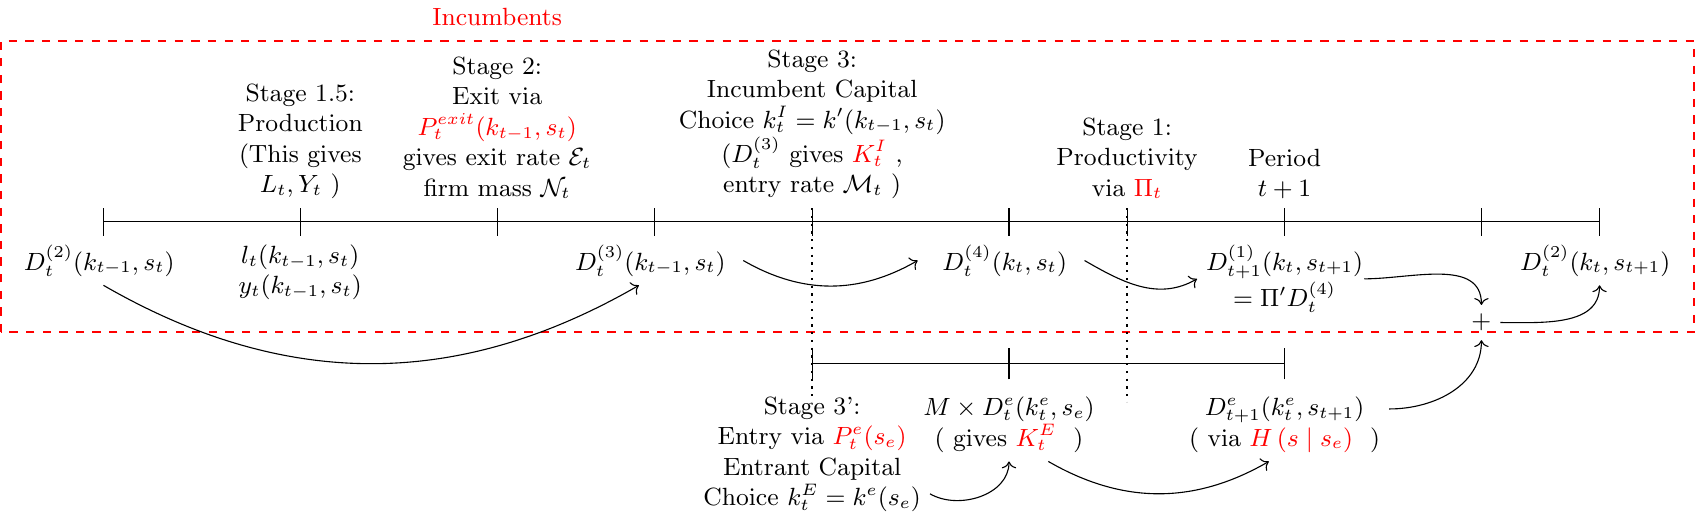

In [14]:
pages = convert_from_path("transition_figs-figure1.pdf", dpi=200)
buffer = BytesIO()
pages[0].save(buffer, format='PNG')
buffer.seek(0)
display(Image(data=buffer.getvalue()))

In [15]:
def firm_entrant_distribution(k_e, P_e, M, k_grid, s_grid, pi_s_e, s_grid_e, Pi_s_e_s):  
    
    # D_e is after the entry choice and with the next productivity draw
    a_i, a_pi = get_lottery(k_e, k_grid)
    D_e = np.zeros((k_e.shape[0], len(s_grid), len(k_grid)))                 # construct entrant distribution
    for n in range(2):
        for q in range(len(s_grid_e)):  # for each signal
            D_e[n,:,a_i[n,q]] += pi_s_e[q] * P_e[n,q] * a_pi[n,q] * Pi_s_e_s[q,:]         # pi_s_e:mass of entrants with signal s_e; P_e is the probability of entry; Pi_s_e_s is the transition matrix  
            D_e[n,:,a_i[n,q]+1] += pi_s_e[q] * P_e[n,q] * (1-a_pi[n,q]) * Pi_s_e_s[q,:]
    return M*D_e
    


In [16]:
# single forward iteration starting from cross-sectional dist of firms that produce
def firm_forward_iteration(D2, k, k_e, P, P_e, M, Pi_s, pi_s_e, s_grid, k_grid, s_grid_e, Pi_s_e_s):

    """D2 is the current cross-sectional distribution over (k,s) right before the production takes place"""
    
    ############## Incumbents ############## 
    
    a_i, a_pi = get_lottery(k, k_grid)     # lotteries for capital choice
        
    ### expand the choice probabilities
    P_new = P.copy()
#     P_new[0,:,:] = 0     # exiters
    b = np.repeat(P_new[:, np.newaxis,:,:], 1, axis=1)
    
    ############## Iterate forward ############## 

    # Stage 2 of period t (exit choice)
    D3 = batch_multiply_ith_dimension(b, 0, D2)

    # Stage 3 of period t  (investment policy)
    D4 = forward_policy(D3, a_i, a_pi)  
    D4[0,:,:] = 0   # exiters
    
    # Stage 1 of period t+1  (productivity shock)
    D1 = Pi_s.T @ D4 

    ############## Entrants using time t policies, but enter in period (t+1) ############## 
    
    D_e = firm_entrant_distribution(k_e, P_e, M, k_grid, s_grid, pi_s_e, s_grid_e, Pi_s_e_s)
    
    # Add mass of the entrants to the mass of survivors
    D_new = D1.copy()
    D_new[1,:,:] += D_e[1,:,:]
    
    # cross-section of period (t+1)
    D2 = D_new.copy()
    
    return D3, D4, D1, D_e, D2

firm_forward_iteration_output = ['D3', 'D4', 'D1', 'D_e', 'D2']



In [17]:
def firm_distribution_ss(k, k_e, P, P_e, M, Pi_s, pi_s_e, s_grid, k_grid, s_grid_e, Pi_s_e_s, iters = 20_000, tol=1E-12):

    # Initialize
    D2 = np.zeros((k.shape)) 
        
    # now iterate until convergence to acceptable threshold
    for c in range(iters):  
        D3, D4, D1, D_e, D2   = firm_forward_iteration(D2, k, k_e, P, P_e, M, Pi_s, pi_s_e, s_grid, k_grid, s_grid_e, Pi_s_e_s)
        if c > 0 and np.max(np.abs(D2_old  - D2)) < tol and np.max(np.abs(D1_old  - D1)) < tol and np.max(np.abs(D3_old  - D3)) < tol and np.max(np.abs(D4_old  - D4)) < tol and np.max(np.abs(D_e_old  - D_e)) < tol:
#             print("Dist converged in", c, "iters")
            return D3, D4, D1, D_e, D2
        D2_old = D2.copy()
        D1_old = D1.copy()
        D3_old = D3.copy()
        D4_old = D4.copy()
        D_e_old = D_e.copy()
        
    if c == iters - 1: print("Not converged") 




### Forward iteration check

In [18]:
# # # SS distribution - (Run Backward iteration check before this)
# start = time.time()
# D3, D4, D1, D_e, D2 = firm_distribution_ss(k, k_e, P, P_e, cali['M'], Pi_s, pi_s_e, s_grid, k_grid, s_grid_e, Pi_s_e_s)
# print("SS distribution take around", np.round( (time.time()-start), 1), "sec")
# print("Mass of entrants:", np.sum(D_e[1,:,:]) )
# print("Mass of entrants:", np.sum(P_e[1,:] * pi_s_e * cali['M']))
# print("Total Mass:", np.sum(D2[1,:,:])  )
# print("Entry Rate:", np.sum(D_e[1,:,:]) / np.sum(D2[1,:,:]) )




## Aggregates

In [19]:
def firm_aggregates(l, y, k, P, k_e, P_e, D2, D3, D_e, k_grid, delta, pi_s_e, s_grid, M):
    
    # Distributions
    Gamma = D2[1,:,:].copy()               # incumbents in period (t) - includes continuing firms from previous period (= S_old) and new entrants (= S_e)
    S_e = D_e[1,:,:].copy()                # entrants (already come with new productivity draw ready to produce)
    S = D3[1,:,:].copy()                   # firms that will continuing next period
    S_c = D3[0,:,:].copy()                 # exiters
    S_e_t = P_e[1,:] * pi_s_e * M          # entrants that decide to enter next period
   
    # mass
    total_mass = np.sum(Gamma)
    entrant_mass = np.sum(S_e)
    survivors_mass = np.sum(S) 
    exiters_mass = np.sum(S_c)
    
    # labor
    total_labor = np.vdot(l, Gamma)
    entrants_labor = np.vdot(l, S_e)
    survivors_labor = np.vdot(l, S)
    exiters_labor = np.vdot(l, S_c)
    
    # average labor
    avg_entrants_labor = entrants_labor / entrant_mass
    avg_survivors_labor = survivors_labor / survivors_mass
    avg_exiters_labor = exiters_labor / exiters_mass
    avg_labor = total_labor / total_mass
    
    # relative size
    entrants_relative_size = avg_entrants_labor / avg_survivors_labor    # relative to non-exiters
    exiters_relative_size = avg_exiters_labor / avg_survivors_labor      # relative to non-exiters
    entrants_relative_size_incumbent = avg_entrants_labor / avg_labor    # relative to incumbents
    exiters_relative_size_incumbent = avg_exiters_labor / avg_labor      # relative to incumbents

    # output
    total_output = np.vdot(y, Gamma)
    
    # Capital demand *this* period
    survivors_capital = np.vdot(k[1,:,:], S)
    entrants_capital = np.vdot(k_e[1,:], S_e_t)
    total_capital = survivors_capital + entrants_capital

    # investment stats
    inv_rate_incumbents = k/k_grid - (1-delta)
    survivors_inv = np.vdot(inv_rate_incumbents[1,:,:], S)
    
    mean_inv_rate = survivors_inv / survivors_mass
    var_inv_rate = np.vdot( (inv_rate_incumbents[1,:,:] - mean_inv_rate)**2, S)  / survivors_mass
    sd_inv_rate = var_inv_rate**(0.5)
    inaction = np.abs(inv_rate_incumbents[1,:,:]) < 0.01
    inaction_rate = np.vdot(inaction, S)  / survivors_mass
    
    # productivity    
    avg_prod = np.vdot(s_grid, np.sum(Gamma, axis=1) ) / total_mass
    avg_exiters_prod = np.vdot(s_grid, np.sum(S_c, axis=1) ) / exiters_mass
    avg_entrants_prod = np.vdot(s_grid, np.sum(S_e, axis=1) ) / entrant_mass

    N = total_labor
    Y = total_output
    K = total_capital
    ENTRY_RATE = entrant_mass/total_mass
    EXIT_RATE = exiters_mass/total_mass
    
    return N, Y, K, ENTRY_RATE, EXIT_RATE, mean_inv_rate, sd_inv_rate, inaction_rate, entrants_relative_size, exiters_relative_size, entrants_relative_size_incumbent, exiters_relative_size_incumbent, avg_prod, avg_exiters_prod, avg_entrants_prod, total_mass

firm_aggregates_output = ['N', 'Y', 'K', 'ENTRY_RATE', 'EXIT_RATE', 'mean_inv_rate', 'sd_inv_rate', 'inaction_rate', 
                          'entrants_relative_size', 'exiters_relative_size', 'entrants_relative_size_incumbent', 'exiters_relative_size_incumbent',
                          'avg_prod', 'avg_exiters_prod', 'avg_entrants_prod', 'total_mass' ]



## Steady State

In [20]:
@simple
def firm_steady_state(w, r, X, M, c_f, c_e, sigma_s, rho_s, ns, ns_e, kmin, kmax, nk, alpha_k, alpha_l, theta, delta, c_1, taste_shock, taste_shock_e, pareto, gamma):
    
    tol=1E-12
    
    # Grids
    s_grid, pi_s, Pi_s, k_grid, s_grid_e, pi_s_e, Pi_s_e_s = firm_make_grid(rho_s, sigma_s, ns, kmin, kmax, nk, ns_e, pareto)
    
    # SS backward iteration
    V1, Va1, V3, Va3, k, div, P, V_e2, k_e, div_e, V_e1, P_e, l, y, profit, profit_k, V2, Va2 = firm_policy_ss(w, r, X, Pi_s, Pi_s_e_s, s_grid, k_grid, alpha_k, alpha_l, theta, delta, c_1, c_f, taste_shock, c_e, taste_shock_e, tol=tol)
    
    # SS forward iterations
    D3, D4, D1, D_e, D2 = firm_distribution_ss(k, k_e, P, P_e, M, Pi_s, pi_s_e, s_grid, k_grid, s_grid_e, Pi_s_e_s, tol=tol)
    
    # Aggregates
    N, Y, K, ENTRY_RATE, EXIT_RATE, mean_inv_rate, sd_inv_rate, inaction_rate, entrants_relative_size, exiters_relative_size, entrants_relative_size_incumbent, exiters_relative_size_incumbent, avg_prod, avg_exiters_prod, avg_entrants_prod, total_mass = firm_aggregates(l, y, k, P, k_e, P_e, D2, D3, D_e, k_grid, delta, pi_s_e, s_grid, M)
    
    return s_grid, pi_s, Pi_s, k_grid, s_grid_e, pi_s_e, Pi_s_e_s, V1, Va1, V3, Va3, k, div, V2, Va2, P, V_e2, k_e, div_e, V_e1, P_e, l, y, profit, profit_k, D3, D4, D1, D_e, D2, N, Y, K, ENTRY_RATE, EXIT_RATE, mean_inv_rate, sd_inv_rate, inaction_rate, entrants_relative_size, exiters_relative_size, entrants_relative_size_incumbent, exiters_relative_size_incumbent, avg_prod, avg_exiters_prod, avg_entrants_prod, total_mass 



### Firm SS check

In [21]:
# start = time.time()
# cali = init_calibration()   
# firm_model = create_model([firm_steady_state])
# firm_ss = firm_model.steady_state(cali)
# print("SS computed in", np.round( (time.time()-start), 1), "sec")




In [22]:
# print_aggregates(firm_ss)


# HH and market clearing

In [23]:
# Define other blocks
@simple
def hh(w, gamma):
    L = w**gamma
    return L

@simple
def mkt_clearing(N,L):  
    labor_mkt = N - L
    return labor_mkt


# Calibration

## Calibration

In [24]:
target = {}
target['ENTRY_RATE'] = 0.062
target['entrants_relative_size_incumbent'] = 0.6


In [25]:
def calibrate_ss(x, target, firm_model, cali, opt=1, print_x = 0):
    
    c_f, pareto = x[0], x[1]       # operating costs, pareto coefficient for entrants' signals
    c_e = c_f                      # set entry cost equal to mean operating cost
    
    cali.update({'c_f':c_f, 'c_e':c_e, 'pareto':pareto})
    
    # compute steady state
    ss_temp = firm_model.steady_state(cali)
    ENTRY_RATE, entrants_relative_size_incumbent = ss_temp['ENTRY_RATE'], ss_temp['entrants_relative_size_incumbent']
    dif = [ENTRY_RATE - target['ENTRY_RATE'], entrants_relative_size_incumbent - target['entrants_relative_size_incumbent']]
    
    if print_x == 1:
        print(x)
        print("outs:", np.round([ENTRY_RATE, entrants_relative_size_incumbent], 4))
        print("dif:", np.round(dif, 4))
    error = 100*dif[0]**2 + dif[1]**2
    
    if opt == 1:
        return error
    else:
        return ss_temp
    
    

In [26]:
cali = init_calibration()   
firm_model = create_model([firm_steady_state])  # firm model SS

# initial values 
c_f_c, pareto_c = [0.005137732201128939, 3.95662179867817]


In [27]:
# check that the function works
res0 = calibrate_ss([c_f_c, pareto_c], target, firm_model, cali, 0, 1) 
res0


[0.005137732201128939, 3.95662179867817]
outs: [0.0618 0.6057]
dif: [-0.0002  0.0057]


<SteadyStateDict: ['w', 'r', 'X', 'M', 'c_f', 'c_e', 'sigma_s', 'rho_s', 'ns', 'ns_e', 'kmin', 'kmax', 'nk', 'alpha_k', 'alpha_l', 'theta', 'delta', 'c_1', 'taste_shock', 'taste_shock_e', 'pareto', 'gamma', 's_grid', 'pi_s', 'Pi_s', 'k_grid', 's_grid_e', 'pi_s_e', 'Pi_s_e_s', 'V1', 'Va1', 'V3', 'Va3', 'k', 'div', 'V2', 'Va2', 'P', 'V_e2', 'k_e', 'div_e', 'V_e1', 'P_e', 'l', 'y', 'profit', 'profit_k', 'D3', 'D4', 'D1', 'D_e', 'D2', 'N', 'Y', 'K', 'ENTRY_RATE', 'EXIT_RATE', 'mean_inv_rate', 'sd_inv_rate', 'inaction_rate', 'entrants_relative_size', 'exiters_relative_size', 'entrants_relative_size_incumbent', 'exiters_relative_size_incumbent', 'avg_prod', 'avg_exiters_prod', 'avg_entrants_prod', 'total_mass']>

### Get bounds for $c_f$ and $\xi$

In [28]:
c_f_list = np.linspace(0.0049, 0.0052, 5) 
ENTRY_RATE_list = np.zeros((5,))
entrants_relative_size_list = np.zeros((5,))

pareto_temp = 3.95662179867817

for c_f_idx, c_f_temp in enumerate(c_f_list):  
    ss_temp = calibrate_ss([c_f_temp, pareto_temp], target, firm_model, cali, opt=0, print_x=0)
    ENTRY_RATE_list[c_f_idx,] = ss_temp['ENTRY_RATE']
    entrants_relative_size_list[c_f_idx,] = ss_temp['entrants_relative_size_incumbent']


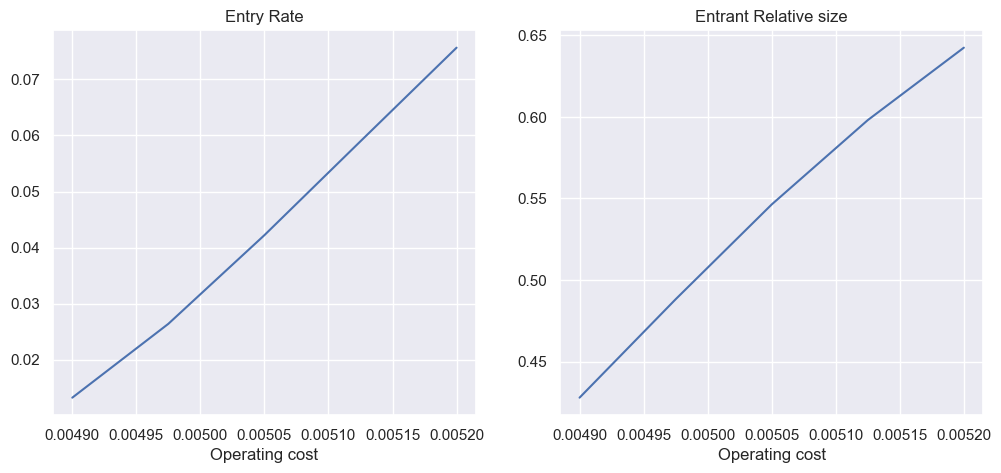

In [29]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(c_f_list, ENTRY_RATE_list )
ax[1].plot(c_f_list, entrants_relative_size_list )
ax[0].set_title('Entry Rate')
ax[1].set_title('Entrant Relative size')
ax[0].set_xlabel('Operating cost')
ax[1].set_xlabel('Operating cost');
 

In [30]:
pareto_c_list = np.linspace(3.0, 4.2, 5) 
ENTRY_RATE_list2 = np.zeros((5,))
entrants_relative_size_list2 = np.zeros((5,))

c_f_temp = 0.005137732201128939

for pareto_idx, pareto_temp in enumerate(pareto_c_list):  
    ss_temp = calibrate_ss([c_f_temp, pareto_temp], target, firm_model, cali, opt=0, print_x=0)
    ENTRY_RATE_list2[pareto_idx,] = ss_temp['ENTRY_RATE']
    entrants_relative_size_list2[pareto_idx,] = ss_temp['entrants_relative_size_incumbent']
    

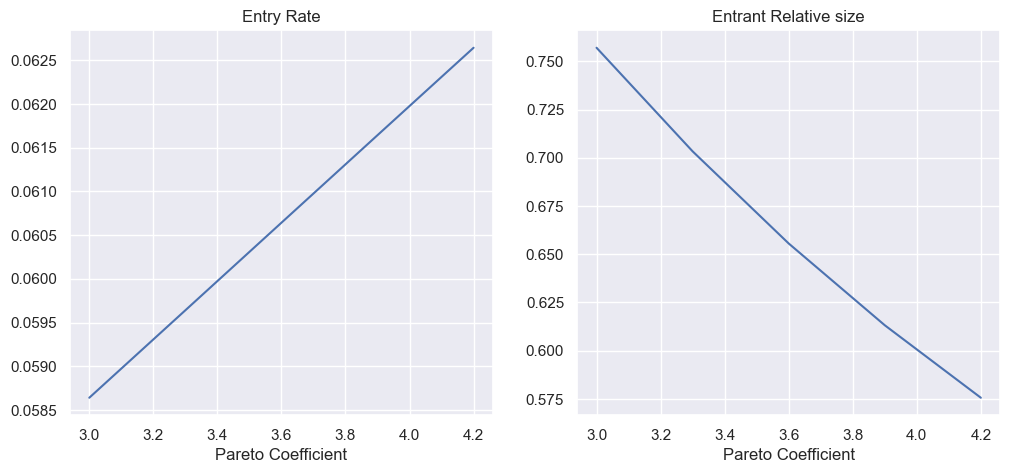

In [31]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(pareto_c_list, ENTRY_RATE_list2 )
ax[1].plot(pareto_c_list, entrants_relative_size_list2 )
ax[0].set_title('Entry Rate')
ax[1].set_title('Entrant Relative size')
ax[0].set_xlabel('Pareto Coefficient')
ax[1].set_xlabel('Pareto Coefficient');


### calibrate $c_f$ and $\xi$

In [32]:
bnds = ((0.0050, 0.0053), (3.7, 4.1))    # very sensitive to operating costs
res = minimize(calibrate_ss, (c_f_c, pareto_c), bounds=bnds, args = (target, firm_model, cali,1,0))


In [33]:
res 


  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 3.5650370330404694e-05
        x: [ 5.138e-03  3.957e+00]
      nit: 1
      jac: [ 1.546e-02 -1.602e-03]
     nfev: 9
     njev: 3
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [34]:
c_f_c, pareto_c = res.x 
c_f_c, pareto_c


(np.float64(0.005137734148145484), np.float64(3.9566218178943555))

### Get bounds for $M$

In [35]:
# Labor demand curve
cali.update({'c_f': c_f_c, 'c_e': c_f_c, 'pareto': pareto_c})

M_list = np.linspace(10, 1000, 5)
L_d = M_list.copy()
L_s = M_list.copy()
for idx, M_temp in enumerate(M_list): 
    cali.update({"M": M_temp}) 
    ss_temp = firm_model.steady_state(cali)
    L_d[idx] = ss_temp['N']
    L_s[idx] = cali['w']**cali['gamma']



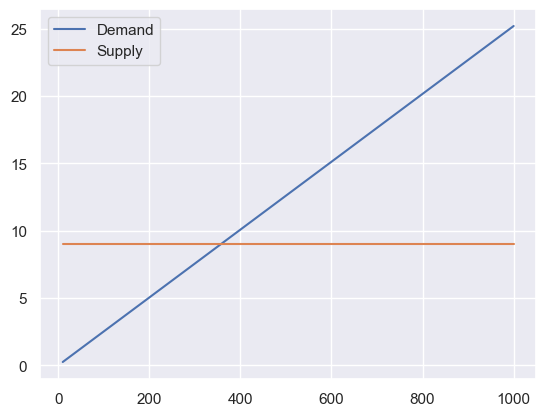

In [36]:
plt.plot(M_list, L_d, label='Demand')
plt.plot(M_list, L_s, label='Supply')
plt.legend()


### Calibrate $M$

In [37]:
# Solve for M to clear labor market
c_f_c, pareto_c = res.x 
cali.update({'c_f': c_f_c, 'c_e': c_f_c, 'pareto': pareto_c})
unknowns_ss = {'M': cali['M'] }
targets_ss = {'N' : cali['w']**cali['gamma']}
ss0 = firm_model.solve_steady_state(cali, unknowns_ss, targets_ss, solver="brentq", solver_kwargs={"bracket": (300, 400)} )



In [38]:
cali.update({"M":ss0['M'], "L":ss0['N']})


## full model SS dict

In [39]:
blocks_ss = [firm_steady_state, hh, mkt_clearing]
cp_model_ss = create_model( blocks_ss  )
print((cp_model_ss.inputs))
print((cp_model_ss.outputs))

del blocks_ss


['w', 'r', 'X', 'M', 'c_f', 'c_e', 'sigma_s', 'rho_s', 'ns', 'ns_e', 'kmin', 'kmax', 'nk', 'alpha_k', 'alpha_l', 'theta', 'delta', 'c_1', 'taste_shock', 'taste_shock_e', 'pareto', 'gamma']
['s_grid', 'pi_s', 'Pi_s', 'k_grid', 's_grid_e', 'pi_s_e', 'Pi_s_e_s', 'V1', 'Va1', 'V3', 'Va3', 'k', 'div', 'V2', 'Va2', 'P', 'V_e2', 'k_e', 'div_e', 'V_e1', 'P_e', 'l', 'y', 'profit', 'profit_k', 'D3', 'D4', 'D1', 'D_e', 'D2', 'N', 'Y', 'K', 'ENTRY_RATE', 'EXIT_RATE', 'mean_inv_rate', 'sd_inv_rate', 'inaction_rate', 'entrants_relative_size', 'exiters_relative_size', 'entrants_relative_size_incumbent', 'exiters_relative_size_incumbent', 'avg_prod', 'avg_exiters_prod', 'avg_entrants_prod', 'total_mass', 'L', 'labor_mkt']


In [40]:
cali_ge = copy.deepcopy(cali)
ss_cp = cp_model_ss.steady_state(cali_ge)



In [41]:
ss_cp['c_f'], ss_cp['c_e'], ss_cp['M'], ss_cp['pareto'], np.log(ss_cp['c_f'])



(np.float64(0.005137734148145484),
 np.float64(0.005137734148145484),
 357.3435813562602,
 np.float64(3.9566218178943555),
 np.float64(-5.271143123916992))

In [42]:
print_aggregates(ss_cp)

,ENTRY_RATE,EXIT_RATE,K,M,N,Y,entrants_relative_size_incumbent,exiters_relative_size,inaction_rate,labor_mkt,mean_inv_rate,r,sd_inv_rate,total_mass,w
value,0.061832,0.061832,79.962252,357.343581,9.0,48.214286,0.60573,0.211721,0.027595,-1.421085e-14,0.151783,0.04,0.322665,1649.595744,3.0


# Calibration tables

## Table 1

In [43]:
# Solve for wage to clear labor market
table1 = {k_idx: ss_cp[k_idx] for k_idx in ('alpha_k','alpha_l', 'theta', 'delta', 'r', 'gamma', 'M',
                                 'rho_s', 'sigma_s', 'c_f', 'c_1', 'pareto', 'c_e')}  
t1 = print_ss(table1)
t1.columns = ['$\\alpha_k$', '$\\alpha_l$', '$\\theta$', '$\\delta$', '$r$', '$\\gamma$', '$M$',
                                 '$\\rho_s$', '$\\sigma_s$', '$c_f$', '$c_1$', '$\\xi$', '$c_e$']
t1 = t1.T.reset_index().rename(columns={0:'Parameter'})
t1.index = ['Capital Share', 'Labor Share', 'Span of control', 'Depreciation rate', 'Interest rate', 'Labor supply elasticity',
            'Mass of potential entrants', 'Persistence idiosyncratic shock', 'Variance idiosyncratic shock',
            'Mean Operating Cost', 'Variable cost of investment', 'Pareto exponent','Entry cost']

t1


,index,value
Capital Share,$\alpha_k$,0.300000
Labor Share,$\alpha_l$,0.700000
Span of control,$\theta$,0.800000
Depreciation rate,$\delta$,0.100000
Interest rate,$r$,0.040000
Labor supply elasticity,$\gamma$,2.000000
Mass of potential entrants,$M$,357.343581
Persistence idiosyncratic shock,$\rho_s$,0.550000
Variance idiosyncratic shock,$\sigma_s$,0.263421
Mean Operating Cost,$c_f$,0.005138


## Table 2

In [44]:

table2 = {k: ss_cp[k] for k in ('mean_inv_rate','sd_inv_rate','inaction_rate',
                                'ENTRY_RATE','entrants_relative_size_incumbent', 'exiters_relative_size')}  
t2 = print_ss(table2)
t2.columns = ['Mean investment rate', 'SD investment rate', 'Inaction rate',  
              'Entry rate', 'Entrants’ relative size', 'Exiters’ relative size']
t2 = np.round(t2, 3)
t2 = t2.T.reset_index().rename(columns={'index':'Statistic'}).set_index('Statistic')
t2



,value
Statistic,
Mean investment rate,0.152
SD investment rate,0.323
Inaction rate,0.028
Entry rate,0.062
Entrants’ relative size,0.606
Exiters’ relative size,0.212


# Steady State firm-dynamics

## Figure 2

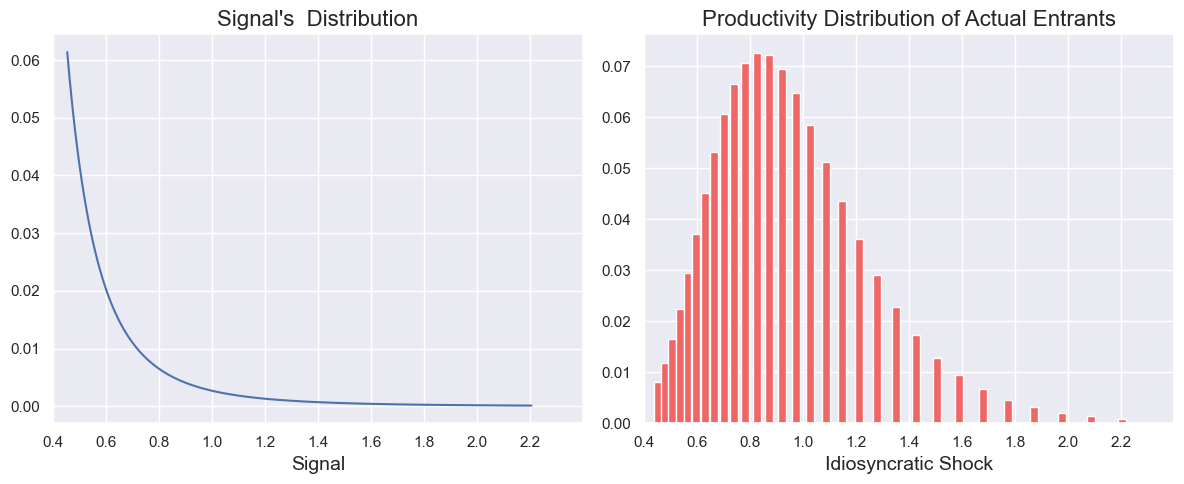

In [45]:

graph_opt = {'axessize':14,'legendsize':12,'titlesize':16,'labelspace':0.2,'labelsize':12, 
             'ncols':2,'figsize':(12, 5), 'nrows':1 }
for k,v in graph_opt.items(): exec('%s=%s'%(k,v))
fig, ax = plt.subplots(nrows, ncols, figsize=figsize)

plt.subplot(nrows,ncols,1)
plt.plot(ss_cp['s_grid_e'], ss_cp['pi_s_e'])
plt.xlabel('Signal', fontsize=axessize)
plt.title('Signal\'s  Distribution', fontsize=titlesize)
plt.xlim([0.4, 2.4])
plt.xticks(np.arange(0.4, 2.4, step=0.2));


plt.subplot(nrows,ncols,2)
# plt.bar(ss_cp['s_grid'], ss_cp['pi_s'], label='Unconditional' , width=0.03)
# plt.plot(ss_cp['s_grid'], ss_cp['pi_s'], label='Unconditional' )

plt.bar(ss_cp['s_grid'], np.sum(ss_cp['D_e'][1,:,:], axis=1) / np.sum(ss_cp['D_e'][1,:,:])   , label='Entrants', width=0.03, color='#EE6666')
plt.xlabel('Idiosyncratic Shock', fontsize=axessize)
plt.title('Productivity Distribution of Actual Entrants', fontsize=titlesize)
# plt.legend();
plt.xlim([0.4, 2.4])
plt.xticks(np.arange(0.4, 2.4, step=0.2));

plt.tight_layout()
plt.savefig('figs/model_fig2.pdf' )


## Figure 4

In [46]:
D4_old = ss_cp['D_e'].copy()   # start from age 0
D4_old[0,:,:] = 0

Tage = 30
exit_rate_age = np.zeros((Tage,1))
avg_prod_age = np.zeros((Tage,1))
avg_labor_age = np.zeros((Tage,1))
Ds = {}
for age in range(len(exit_rate_age)):
    
    D3, D4, D1, D_e, D2 = firm_forward_iteration(D4_old, ss_cp['k'], ss_cp['k_e'], ss_cp['P'], ss_cp['P_e'],
                                               ss_cp['M'], ss_cp['Pi_s'], ss_cp['pi_s_e'],
                                               ss_cp['s_grid'], ss_cp['k_grid'], ss_cp['s_grid_e'], ss_cp['Pi_s_e_s'])

    exit_rate_age[age] = 1 - np.sum(D1)/np.sum(D4_old)
    avg_prod_age[age] = np.vdot(ss_cp['s_grid'], np.sum( D4_old[1,:,:], axis=1) ) / np.sum(D4_old[1,:,:])
    avg_labor_age[age] = np.vdot(ss_cp['l'], D4_old[1,:,:]) / np.sum(D4_old[1,:,:])

    Ds[str(age)] = D4_old.copy()
    
    D4_old = D1.copy()
    

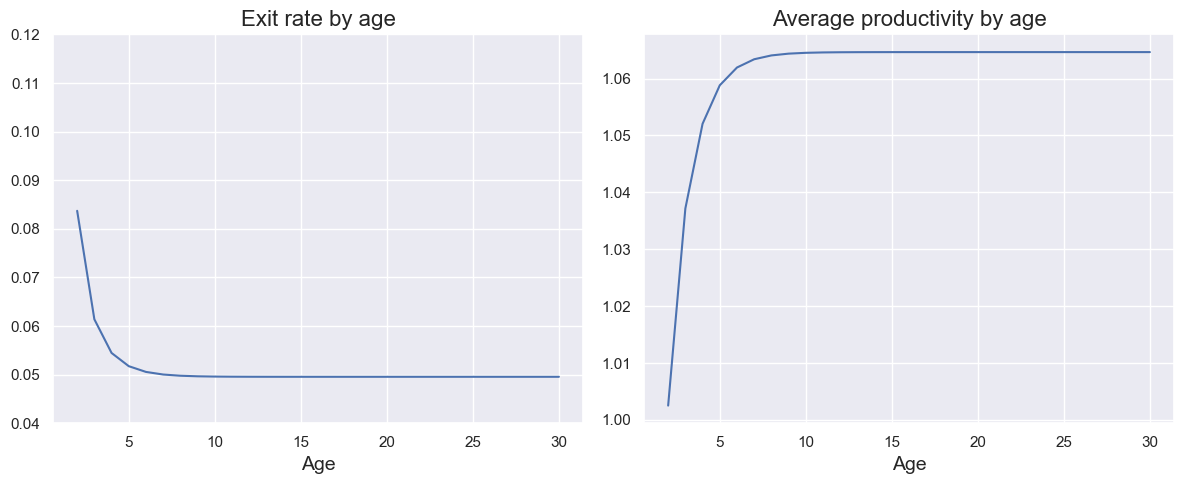

In [47]:
graph_opt = {'axessize':14,'legendsize':12,'titlesize':16,'labelspace':0.2,'labelsize':12, 
             'ncols':2,'figsize':(12, 5), 'nrows':1 }
for k,v in graph_opt.items(): exec('%s=%s'%(k,v))
fig, ax = plt.subplots(nrows, ncols, figsize=figsize)

plt.subplot(nrows,ncols,1)
plt.plot(np.linspace(2, Tage, Tage-1), exit_rate_age[1:])
plt.xlabel('Age', fontsize=axessize)
plt.title('Exit rate by age', fontsize=titlesize)
plt.ylim([0.04, 0.12])

plt.subplot(nrows,ncols,2)
plt.plot(np.linspace(2, Tage, Tage-1), avg_prod_age[1:])
plt.xlabel('Age', fontsize=axessize)
plt.title('Average productivity by age', fontsize=titlesize)

plt.tight_layout()

plt.savefig('figs/model_fig4.pdf' )


## Figure 6

In [48]:
ls = np.reshape( ss_cp['l'], (ss_cp['ns']*ss_cp['nk'], ) )
ds = np.reshape( ss_cp['D2'][1,:,:] , (ss_cp['ns']*ss_cp['nk'],  ) )


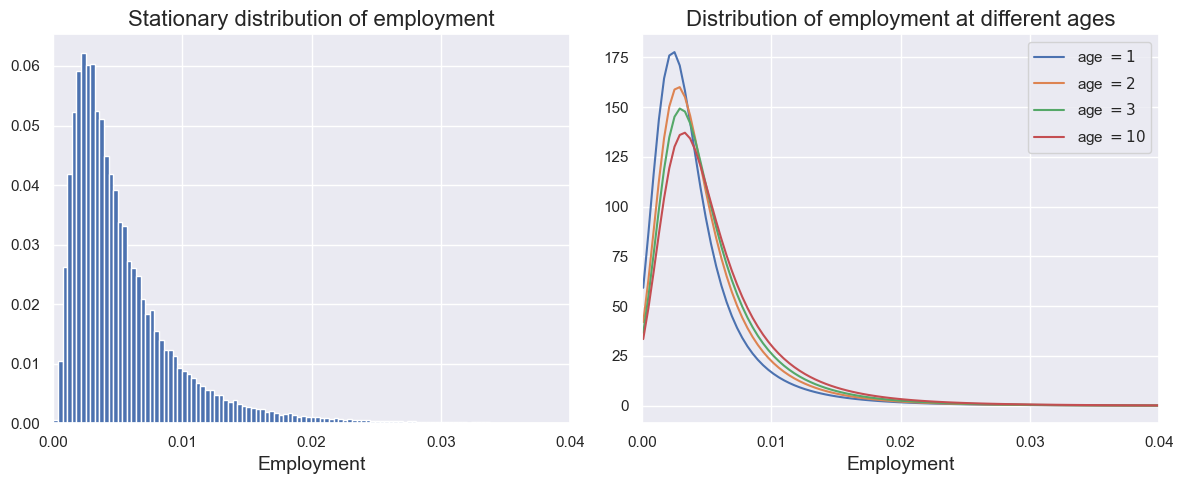

In [49]:
graph_opt = {'axessize':14,'legendsize':12,'titlesize':16,'labelspace':0.2,'labelsize':12, 
             'ncols':2,'figsize':(12, 5), 'nrows':1 }
for k,v in graph_opt.items(): exec('%s=%s'%(k,v))
fig, ax = plt.subplots(nrows, ncols, figsize=figsize)

plt.subplot(nrows,ncols,1)
plt.hist(ls, 500, weights=ds/np.sum(ds))  #, histtype =  'step'
plt.xlim([0,0.04]);
plt.xticks(np.arange(0, 0.041, step=0.01));
plt.xlabel('Employment', fontsize=axessize)
plt.title('Stationary distribution of employment', fontsize=titlesize)


plt.subplot(nrows,ncols,2)
for age in [1, 2, 3, 10]:
    ds = np.reshape(Ds[str(age)][1,:,:] , (ss_cp['ns']*ss_cp['nk'],  ) )
    kernel = scipy.stats.gaussian_kde(ls, weights=ds/np.sum(ds))
    pts = np.linspace(0.0001, 0.04, 100)
    a = kernel.evaluate(pts)
    
    plt.plot(pts, a,  label=f'age $={age}$') 
    plt.xlim([0,0.04]);
    plt.xticks(np.arange(0, 0.041, step=0.01));
    plt.xlabel('Employment', fontsize=axessize)
    plt.title('Distribution of employment at different ages', fontsize=titlesize)
plt.legend();
plt.tight_layout()

plt.savefig('figs/model_fig6.pdf' )





# Transition


In [50]:
# rho and shock size are same as the paper
rho = 0.685
T = 200
Tend = 40
shock_size_nl = 0.0233 * 1.5 
shock_size_jacobian = 0.0001


## Functions for backward and forward iterations on transition

In [51]:
print(firm_backward_iteration_output)

['V1', 'Va1', 'V3', 'Va3', 'k', 'div', 'P', 'V_e2', 'k_e', 'div_e', 'V_e1', 'P_e', 'profit', 'profit_k', 'l', 'y', 'V2', 'Va2']


In [52]:
def firm_backward_iteration_transition(w_path, r_path, X_path, ss, firm_backward_iteration_outputs):
    
    T = len(w_path)
    
    # backward iteration
    V2, Va2 = ss['V2'], ss['Va2']    # initialize with steady-state

    # empty arrays to store paths
    pol_paths = {}
    for pol in firm_backward_iteration_outputs:
        pol_paths[pol] = np.empty((T,) + ss[pol].shape) 
            
    backward_inputs_t = {k_i: ss[k_i] for k_i in ('Pi_s', 'Pi_s_e_s', 's_grid', 'k_grid',  'alpha_k', 'alpha_l', 
                                            'theta', 'delta', 'c_1', 'c_f', 
                                            'taste_shock', 'c_e', 'taste_shock_e', 
                                            )}  
    # Iterate backwards
    for t in reversed(range(T)):
        
        output_temp =  firm_backward_iteration(V=V2, Va=Va2, w=w_path[t], r=r_path[t], X=X_path[t], **backward_inputs_t)
        
        # save (all are time t policies and values)
        for pol_idx, pol in enumerate(firm_backward_iteration_outputs):
            pol_paths[pol][t] = output_temp[pol_idx]
        
        V2, Va2 = pol_paths['V2'][t], pol_paths['Va2'][t] 
        del output_temp
        
    return pol_paths
        

In [53]:
def firm_forward_iteration_transition(pol_paths, ss):

    T = len(pol_paths['k'])
    
    # forward iteration
    D1s, D_es, D2s = [np.empty((T+1,) + ss['D1'].shape) for _ in range(3)] 
    D3s, D4s = [np.empty((T,) + ss['D1'].shape) for _ in range(2)] 
    
    # initialize with steady-state
    D1s[0]  = ss['D1']
    D_es[0] = ss['D_e']
    D2s[0]  = ss['D2'] 
        
    forward_inputs = {k_i: ss[k_i] for k_i in ('M', 'Pi_s', 'pi_s_e', 's_grid', 'k_grid', 's_grid_e', 'Pi_s_e_s')} # parameters (non-changing)
    
    # Iterate Forward
    for t in range(T):
        D3s[t], D4s[t], D1s[t+1], D_es[t+1], D2s[t+1]  = firm_forward_iteration(D2s[t], pol_paths['k'][t],
                                                                      pol_paths['k_e'][t], 
                                                                      pol_paths['P'][t], 
                                                                      pol_paths['P_e'][t] , **forward_inputs)

    dist_paths = {}
    dist_paths['D1'] = D1s.copy()
    dist_paths['D2'] = D2s.copy()
    dist_paths['D3'] = D3s.copy()
    dist_paths['D4'] = D4s.copy()
    dist_paths['D_e'] = D_es.copy()
    
    return dist_paths
        

In [54]:
print(firm_aggregates_output)

['N', 'Y', 'K', 'ENTRY_RATE', 'EXIT_RATE', 'mean_inv_rate', 'sd_inv_rate', 'inaction_rate', 'entrants_relative_size', 'exiters_relative_size', 'entrants_relative_size_incumbent', 'exiters_relative_size_incumbent', 'avg_prod', 'avg_exiters_prod', 'avg_entrants_prod', 'total_mass']


In [55]:
def firm_aggregates_transition(pol_paths, dist_paths, ss, firm_aggregates_outputs):
    
    T = len(pol_paths['k'])
    
    # Aggregates
    agg_paths = {}
    for agg in firm_aggregates_outputs:
        agg_paths[agg] = np.empty((T,))
         
        
    aggregate_inputs = {k_i: ss[k_i] for k_i in ('k_grid', 'delta', 'pi_s_e',  's_grid', 'M')} # parameters (non-changing)

    for t in range(T): 

        aggregates_temp = firm_aggregates(pol_paths['l'][t], pol_paths['y'][t], pol_paths['k'][t], pol_paths['P'][t], 
                                     pol_paths['k_e'][t], pol_paths['P_e'][t], 
                                     dist_paths['D2'][t], dist_paths['D3'][t], dist_paths['D_e'][t],  
                                     **aggregate_inputs)

    
        # save (all are time t policies and values)
        for agg_idx, agg in enumerate(firm_aggregates_outputs):
            agg_paths[agg][t] = aggregates_temp[agg_idx]

        del aggregates_temp
         
    return agg_paths



Firm Block is
$$\{X_s, r_s, w_s\}_{s=0}^T \quad \rightarrow  \quad \{Y_t, N_t, K_t \}$$

In [56]:
def firm_transition(w_path, r_path, X_path, ss, firm_backward_iteration_outputs, firm_aggregates_outputs):
    
    """{X_s, r_s, w_s}_{s=0}^T -> Aggregates"""
    
    T = len(w_path)

    # backward iteration
    pol_paths = firm_backward_iteration_transition(w_path, r_path, X_path, ss, firm_backward_iteration_outputs)

    # forward iteration
    dist_paths = firm_forward_iteration_transition(pol_paths, ss)
    
    # aggregates
    agg_paths = firm_aggregates_transition(pol_paths, dist_paths, ss, firm_aggregates_outputs)
    agg_paths['w'] = w_path.copy()
    agg_paths['r'] = r_path.copy()
    agg_paths['X'] = X_path.copy()
    
    return pol_paths, dist_paths, agg_paths


In [57]:
# # check firm-side transition
# shock_size_temp = 0.0001
# T_temp = 200
# rho_temp = 0.5
# r_temp = 0*rho_temp**(np.arange(T_temp)) + ss_cp['r']
# w_temp = 0*rho_temp**(np.arange(T_temp)) + ss_cp['w']
# X_temp = shock_size_temp*rho_temp**(np.arange(T_temp)) + ss_cp['X']
# pol_paths_check, dist_paths_check, agg_paths_check = firm_transition(w_temp, r_temp, X_temp, ss_cp, firm_backward_iteration_output, firm_aggregates_output)




## Firm-side Jacobian functions

In [58]:
# single shock at single time
def construct_shock(which_shock, ss, shock_size, s, T):
    
    if which_shock == 'X':
        X_s = shock_size*(np.arange(T) == s) + ss['X']
        w_s = 0*(np.arange(T) == s) + ss['w']
        r_s = 0*(np.arange(T) == s) + ss['r']
    elif which_shock == 'w': 
        X_s = 0*(np.arange(T) == s) + ss['X']
        w_s = shock_size*(np.arange(T) == s) + ss['w']
        r_s = 0*(np.arange(T) == s) + ss['r']
    elif which_shock == 'r': 
        X_s = 0*(np.arange(T) == s) + ss['X']
        w_s = 0*(np.arange(T) == s) + ss['w']
        r_s = shock_size*(np.arange(T) == s) + ss['r']

    return w_s, r_s, X_s


In [59]:
def construct_jacobian_dict(agg_path, ss, shock_size):

    firm_inputs = list(agg_path.keys())
    firm_outputs = list(agg_path[firm_inputs[0]][0].keys())
    T = len(agg_path[firm_inputs[0]][0][firm_outputs[0]])

    # Jacobain matrix
    J = {}
    for idx, which_pol in enumerate(firm_outputs):
        Jpol = {}
        for which_shock in firm_inputs:
            temp = np.zeros((T, T))
            for s in range(T):
                for t in range(T):
                    temp[t, s] = (agg_path[which_shock][s][which_pol][t] - ss[which_pol]) / shock_size

            Jpol[which_shock] = temp.copy()

        J[which_pol] = Jpol.copy()
        del Jpol, temp

    return JacobianDict(J)  # dict


In [60]:
# TxT transition to compute firm Jacobians
def compute_firm_Jacobian(T, shock_size, ss, firm_backward_iteration_outputs, firm_aggregates_outputs, firm_inputs = ['w','X'], print_time=1):

    print("Constructing Jacobian Dict with t = ", T, "and shock size = ", shock_size)
    
    policy_path_s_shocks = {}
    dist_path_s_shocks = {}
    agg_path_s_shocks = {}

    for which_shock in firm_inputs:  # two inputs to the firm problem (r is constant here)

        start = time.time()

        ############## SINGLE BACKWARD ITERATION at s=T-1 ############## 
        policy_paths_s = {}

        # 1. Perturb at s = T-1 
        s = T - 1
        w_path, r_path, X_path = construct_shock(which_shock, ss, shock_size, s, T)

        # (this gives us the last column for policies)
        policy_paths_s[s] = firm_backward_iteration_transition(w_path, r_path, X_path, ss, firm_backward_iteration_outputs)

        # 2. compute policies at all other s \ne T-1
        pol_keys = list(policy_paths_s[T-1].keys())
        for s in reversed(range(T-1)):                    # for each news (i.e. column)
            temp_pol = {}
            for idx, which_pol in enumerate(pol_keys):    # for each policy + value
                temp_t = {}
                for t in range(T):                        # for each t (i.e. row)
                    if t <= s:
                        temp_t[t] = policy_paths_s[T-1][which_pol][T-1-(s-t)]
                    if t > s:
                        temp_t[t] = ss[which_pol]
                temp_pol[which_pol] = temp_t.copy()
                del temp_t

            policy_paths_s[s] = temp_pol.copy()
            del temp_pol

        if print_time == 1: print("Backward iteration done! Time elapsed:", np.round( (time.time()-start)/60, 2), "min")

        ############## FORWARD AND AGGREGATES ############## 
        # use policies for distribution (can be sped up using fake news, not done here)
        dist_paths_s = {}
        agg_paths_s = {}

        for s in range(T):
            # shocks
            w_path, r_path, X_path = construct_shock(which_shock, ss, shock_size_jacobian, s, T)

            dist_paths_s[s] = firm_forward_iteration_transition(policy_paths_s[s], ss )
            agg_paths_s[s] = firm_aggregates_transition(policy_paths_s[s], dist_paths_s[s], ss, firm_aggregates_outputs)
            
        if print_time == 1: print("Forward iteration done! Time elapsed:", np.round( (time.time()-start)/60, 2), "min")

        agg_path_s_shocks[which_shock] = agg_paths_s.copy()

        del policy_paths_s, dist_paths_s, agg_paths_s

    del policy_path_s_shocks, dist_path_s_shocks
    
    # convert to dict
    J_firm = construct_jacobian_dict(agg_path_s_shocks, ss, shock_size)
    
    return agg_path_s_shocks, J_firm



## TFP Shocks

### compute firm jacobians

In [61]:
T, shock_size_jacobian 

(200, 0.0001)

In [62]:
agg_path_s_shocks, J_firm = compute_firm_Jacobian(T, shock_size_jacobian, ss_cp, firm_backward_iteration_output, firm_aggregates_output )



Constructing Jacobian Dict with t =  200 and shock size =  0.0001
Backward iteration done! Time elapsed: 0.02 min
Forward iteration done! Time elapsed: 0.86 min
Backward iteration done! Time elapsed: 0.02 min
Forward iteration done! Time elapsed: 0.84 min


### linear impulse responses using Jacobian Dict

In [63]:
# define model 
blocks = [J_firm, hh, mkt_clearing]
cp_model = create_model( blocks  )
print((cp_model.inputs))
print((cp_model.outputs))



['w', 'X', 'gamma']
['N', 'Y', 'K', 'ENTRY_RATE', 'EXIT_RATE', 'mean_inv_rate', 'sd_inv_rate', 'inaction_rate', 'entrants_relative_size', 'exiters_relative_size', 'entrants_relative_size_incumbent', 'exiters_relative_size_incumbent', 'avg_prod', 'avg_exiters_prod', 'avg_entrants_prod', 'total_mass', 'L', 'labor_mkt']


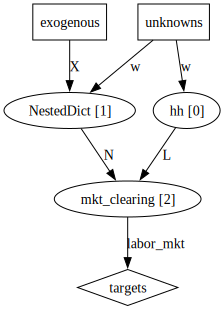

In [64]:
unknowns = ['w'  ]
targets = ['labor_mkt' ]
inputs = ['X' ]
drawdag(cp_model, inputs, unknowns, targets, save=True)



In [65]:
shock_size_jacobian, rho, T

(0.0001, 0.685, 200)

In [66]:
dX = shock_size_jacobian*rho**(np.arange(T))
    
# linear transition
exogenous = {'X': dX}
G_r = cp_model.solve_impulse_linear(ss_cp, unknowns, targets, exogenous ) # DOES NOT TAKE ss_cp directly (need to flatten it first)



### Plots

In [67]:
scale_up = shock_size_nl / shock_size_jacobian
Tplot = 25
Tminus = 0


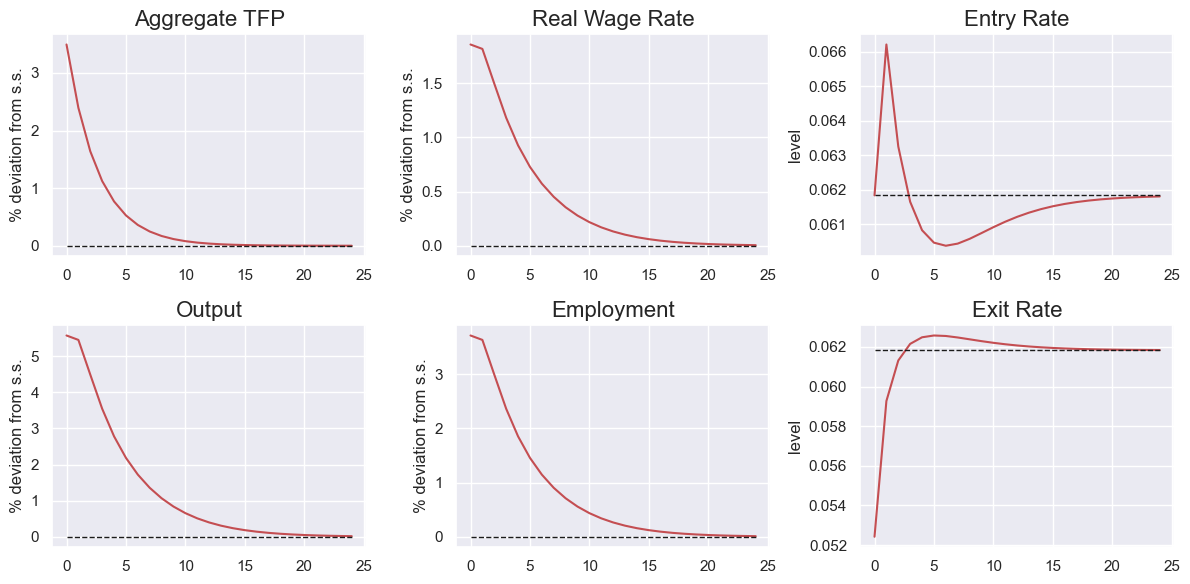

In [68]:
vars_to_plot = ['X', 'w', 'ENTRY_RATE', 'Y', 'N', 'EXIT_RATE'
               ]
titles = [var_names[idx][0] for idx in vars_to_plot]

graph_opt = {'axessize':14,'legendsize':12,'titlesize':16,'labelspace':0.2,'labelsize':12, 
             'ncols':3,'figsize':(12, 6) }
for k,v in graph_opt.items(): exec('%s=%s'%(k,v))
nrows  = int(np.ceil(len(vars_to_plot) / ncols)) 

fig, ax = plt.subplots(nrows, ncols, figsize=figsize)

for i,k in enumerate(vars_to_plot): 
    plt.subplot(nrows,ncols,i+1)
    plt.title(titles[i], fontsize=titlesize)
    if k in ['ENTRY_RATE', 'EXIT_RATE']:
        plt.plot(( G_r[k][:Tplot] * scale_up +  ss_cp[k] )  , color='r')
        plt.plot( ss_cp[k] * np.ones(Tplot)   , color='k', linestyle="--", linewidth=1)
        plt.ylabel('level')
    else:
        plt.plot(( (G_r[k][:Tplot]) / ss_cp[k] * 100 * scale_up ) , color='r')
        plt.plot( ss_cp[k] * np.zeros(Tplot)   , color='k', linestyle="--", linewidth=1)
        plt.ylabel(r'% deviation from s.s.')
plt.tight_layout();
plt.savefig('figs/model_fig9.pdf' )




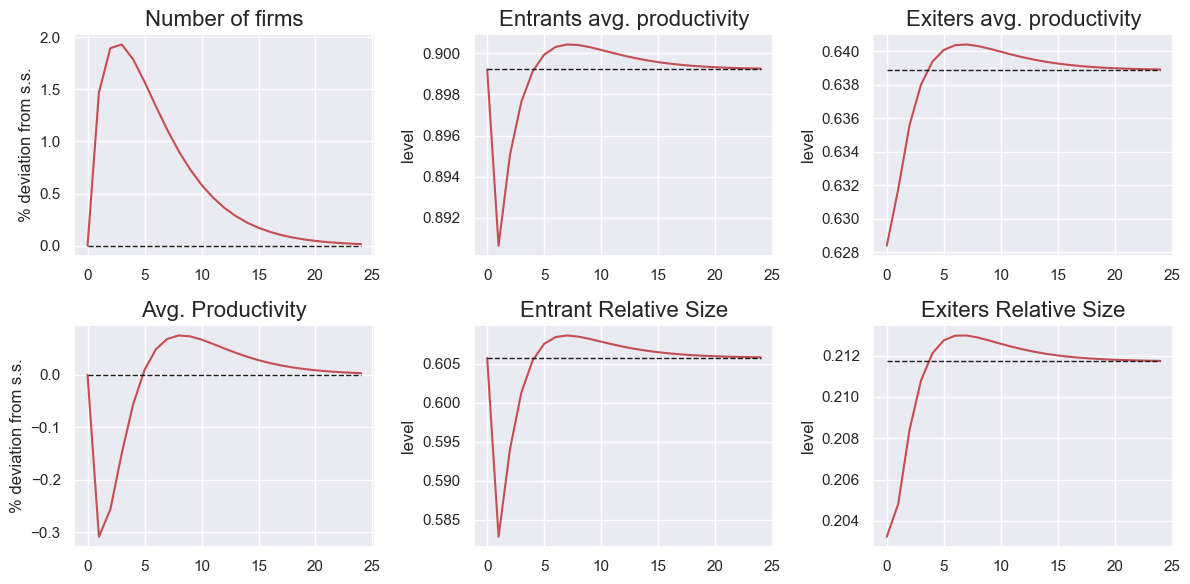

In [69]:
vars_to_plot = ['total_mass', 'avg_entrants_prod', 'avg_exiters_prod','avg_prod',
                'entrants_relative_size_incumbent', 'exiters_relative_size']

titles = [var_names[idx][0] for idx in vars_to_plot]

graph_opt = {'axessize':14,'legendsize':12,'titlesize':16,'labelspace':0.2,'labelsize':12, 
             'ncols':3,'figsize':(12, 6) }
for k,v in graph_opt.items(): exec('%s=%s'%(k,v))
nrows  = int(np.ceil(len(vars_to_plot) / ncols)) 

fig, ax = plt.subplots(nrows, ncols, figsize=figsize)

for i,k in enumerate(vars_to_plot): 
    plt.subplot(nrows,ncols,i+1)
    plt.title(titles[i], fontsize=titlesize)
    if k in ['avg_entrants_prod', 'avg_exiters_prod','entrants_relative_size_incumbent','exiters_relative_size' ]:
        plt.plot(( G_r[k][:Tplot] * scale_up +  ss_cp[k] )  , color='r')
        plt.plot( ss_cp[k] * np.ones(Tplot)   , color='k', linestyle="--", linewidth=1)
        plt.ylabel('level')
    else:
        plt.plot(( (G_r[k][:Tplot]) / ss_cp[k] * 100 * scale_up ) , color='r')
        plt.plot( ss_cp[k] * np.zeros(Tplot)   , color='k', linestyle="--", linewidth=1)
        plt.ylabel(r'% deviation from s.s.')
plt.tight_layout();
plt.savefig('figs/model_fig10.pdf' )



### business cycle statistics

In [70]:
Y_path = G_r['Y']
entry_rate_path = G_r['ENTRY_RATE']
exit_rate_path = G_r['EXIT_RATE']
entrant_size_path = G_r['entrants_relative_size_incumbent']
exit_size_path = G_r['exiters_relative_size']

# correlation with GDP
r1 = scipy.stats.pearsonr(Y_path, entry_rate_path)
r2 = scipy.stats.pearsonr(Y_path, exit_rate_path)
r3 = scipy.stats.pearsonr(Y_path, entrant_size_path)
r4 = scipy.stats.pearsonr(Y_path, exit_size_path)


In [71]:
# Solve for wage to clear labor market
table5 = {'Entry rate':r1[0], 'Exit rate':r2[0], 'Entrants’ size':r3[0], 'Exiters’ size':r4[0]}  
print_ss(table5)



,Entry rate,Exit rate,Entrants’ size,Exiters’ size
value,0.274507,-0.574957,-0.6072,-0.73612
